In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [54]:
telecom_df_base=pd.read_csv('telecom_churn_data.csv', encoding='iso-8859-1')
telecom_plot_base=telecom_df_base.reset_index()
master_df=telecom_df_base.copy()
print(telecom_df_base.shape)

(99999, 226)


### Utilities method

In [55]:
def null_na_estimator_grph(data_f,limit_val=None,graphical=False,size=(None,None)):
    """will return the % amount of null in data frame
       df: panda.DataFrame
       limit_val= (default=None) threshold value, example if limit_val=7, the estimator will return na with >=7
    """
    df=data_f.copy()
    est_ser=est_ser= (round(df.isna().sum()/len(df.index)*100,2)).sort_values(ascending=False)
    if limit_val!=None:
        est_ser= est_ser[est_ser>=limit_val]
    if graphical==True:
        df=pd.DataFrame(est_ser).reset_index()
        plt.figure(figsize=size)
        plt.xticks(rotation=90)
        fig=sns.barplot(data=df,x='index',y=0)
        fig.set_ylabel('Percentage')
        return fig
    else:
        return est_ser

def data_set_structure(df,return_tuple=False):
    """It will return the structure of dataframe or columns tuple as list
    out: tuple (non-num,num,month_6,month_7,month_8,month_9)
       : datafram ->structuring the complete dataset bifurcation
    """
    df_col=df.columns
    if len(df.describe().columns)!=len(df_col):
        non_num_col=df.describe(include=['object']).columns
    else:
        non_num_col=pd.Index([])
    num_col=df_col.difference(non_num_col)
    data_col_month=[x for x in df_col if re.search('_[0-9]$',x)!=None]
    col_9=[x for x in df_col if re.search('_9',x)!=None]
    col_8=[x for x in df_col if re.search('_8',x)!=None]
    col_7=[x for x in df_col if re.search('_7',x)!=None]
    col_6=[x for x in df_col if re.search('_6',x)!=None]
    col_9_n=[x for x in num_col if re.search('_9',x)!=None]
    col_8_n=[x for x in num_col if re.search('_8',x)!=None]
    col_7_n=[x for x in num_col if re.search('_7',x)!=None]
    col_6_n=[x for x in num_col if re.search('_6',x)!=None]
    
    if return_tuple==True:
        return non_num_col.tolist(),num_col.tolist(),col_6,col_7,col_8,col_9
    else:
        result=pd.DataFrame({'Month 6':[abs(len(col_6_n)-len(col_6)),len(col_6_n)],
                             'Month 7':[abs(len(col_7_n)-len(col_7)),len(col_7_n)],
                             'Month 8':[abs(len(col_8_n)-len(col_8)),len(col_8_n)],
                             'Month 9':[abs(len(col_9_n)-len(col_9)),len(col_9_n)]
                    },index=['Non-Numeric','Numeric'])
        result['Common']=[len(non_num_col)-(result.loc['Non-Numeric'].sum()),len(num_col)-(result.iloc[1,:].sum())]
        result['Total']=[result.loc['Non-Numeric'].sum(),result.loc['Numeric'].sum()]
        return result

def data_loss(df_old,df_new):
    """will be calculating the data loss been made in the dataframe"""
    df=pd.DataFrame({'Col loss':round(100*((len(df_old.columns)-len(df_new.columns))/len(df_old.columns)),2),
                    'Row loss':round(100*((len(df_old.index)-len(df_new.index))/len(df_old.index)),2),
                    'Data Retained':round(100*(len(df_new.columns)*len(df_new.index))/(len(df_old.columns)*len(df_old.index)),2)},index=['Percentage'])
    return df

def val_variance_estimator(dataFrame,graphical=False,size=(None,None),graph_filter_limit_max=0):
    variance_graph={}
    for i in range(0,len(dataFrame.columns)):
        variance_graph[dataFrame.columns[i]]=len(dataFrame.loc[:,dataFrame.columns[i]].unique())
    variance_graph_df=pd.DataFrame({'var':list(variance_graph.keys()),'count':list(variance_graph.values())})
    if graphical==True:
        plt.figure(figsize=size)
        plt.xticks(rotation=90)
        text_title='Value Variance Graph < '+str(graph_filter_limit_max)
        plt.title(text_title)
        fig=sns.barplot(x='var',y='count',data=variance_graph_df[variance_graph_df['count']<graph_filter_limit_max].sort_values(by='count',ascending=True))
        return fig
    else:
        return variance_graph_df


##### Fixing structural Error

In [56]:
telecom_df_base.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8','sep_vbc_3g':'vbc_3g_9'},inplace=True)
telecom_df_base[['vbc_3g_6','vbc_3g_7','vbc_3g_8','vbc_3g_9']].head()

,vbc_3g_6,vbc_3g_7,vbc_3g_8,vbc_3g_9
0,101.20,0.0,30.4,3.58
1,0.00,0.0,0.0,0.00
2,4.17,0.0,0.0,0.00
3,0.00,0.0,0.0,0.00
4,0.00,0.0,0.0,0.00


In [57]:
non_num_col,num_col,col_6,col_7,col_8,col_9=data_set_structure(telecom_df_base,return_tuple=True)
data_set_structure(telecom_df_base).head()

,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,3,3,3,3,0,12
Numeric,52,52,52,52,6,214


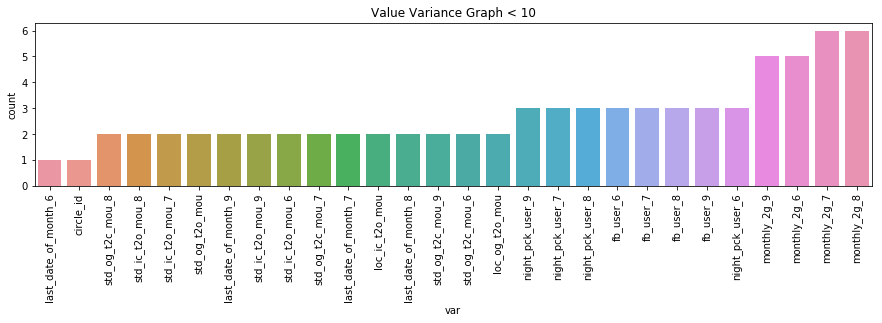

In [58]:
variance_graph_df=val_variance_estimator(telecom_df_base)
val_variance_estimator(telecom_df_base,True,(15,3),graph_filter_limit_max=10)

##### Dropping columns not having more than 2 values

In [59]:
#Revisiting the data which don't have variance equal to 1 or 2
variance_graph_df[variance_graph_df['count']<=2]['var']
for i in variance_graph_df[variance_graph_df['count']<=2]['var']:
    print(i," :",telecom_df_base.loc[:,i].unique())
drop_col=list(variance_graph_df[variance_graph_df['count']<=2]['var'])
#Dropping columns with just 2 values
print("As the value of these columns just have 2 values, which is not adding any information, we are going to drop them. As imputing them doesn't make sense")
telecom_df_base.drop(columns=drop_col,inplace=True)

std_og_t2c_mou_7  : [nan  0.]
last_date_of_month_8  : ['8/31/2014' nan]
std_og_t2c_mou_6  : [nan  0.]
std_og_t2c_mou_9  : [nan  0.]
loc_ic_t2o_mou  : [ 0. nan]
loc_og_t2o_mou  : [ 0. nan]
circle_id  : [109]
last_date_of_month_6  : ['6/30/2014']
std_ic_t2o_mou_9  : [nan  0.]
last_date_of_month_9  : ['9/30/2014' nan]
std_og_t2o_mou  : [ 0. nan]
std_ic_t2o_mou_7  : [nan  0.]
std_ic_t2o_mou_8  : [ 0. nan]
std_og_t2c_mou_8  : [ 0. nan]
std_ic_t2o_mou_6  : [nan  0.]
last_date_of_month_7  : ['7/31/2014' nan]
As the value of these columns just have 2 values, which is not adding any information, we are going to drop them. As imputing them doesn't make sense


In [60]:
print(data_loss(master_df,telecom_df_base))
data_set_structure(telecom_df_base).head()

            Col loss  Data Retained  Row loss
Percentage      7.08          92.92       0.0


,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,2,2,2,2,0,8
Numeric,50,50,50,50,2,202


#### Imputing values for important columns

In [61]:
#As some columns will be used in analysis and the value range is only between 0,1,na, we are going to impute them with a new class i.e. -1 for na

for i in variance_graph_df.loc[(variance_graph_df['count']==3)]['var']:
    print(i," :",telecom_df_base.loc[:,i].unique())
impute_col=list(variance_graph_df[variance_graph_df['count']==3]['var'])

print("Imputing a new category of -1 reprsenting a miss: ",impute_col)

telecom_df_base[impute_col]=telecom_df_base[impute_col].fillna(-1)
impute_col=['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9',
            'total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
            'max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9']

print("Imputing 0 for missing values: ",impute_col)
telecom_df_base[impute_col]=telecom_df_base[impute_col].fillna(0)

night_pck_user_8  : [ 0. nan  1.]
fb_user_8  : [ 1. nan  0.]
fb_user_7  : [ 1. nan  0.]
fb_user_9  : [nan  1.  0.]
night_pck_user_6  : [ 0. nan  1.]
fb_user_6  : [ 1. nan  0.]
night_pck_user_7  : [ 0. nan  1.]
night_pck_user_9  : [nan  0.  1.]
Imputing a new category of -1 reprsenting a miss:  ['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_9', 'night_pck_user_6', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_9']
Imputing 0 for missing values:  ['av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9']


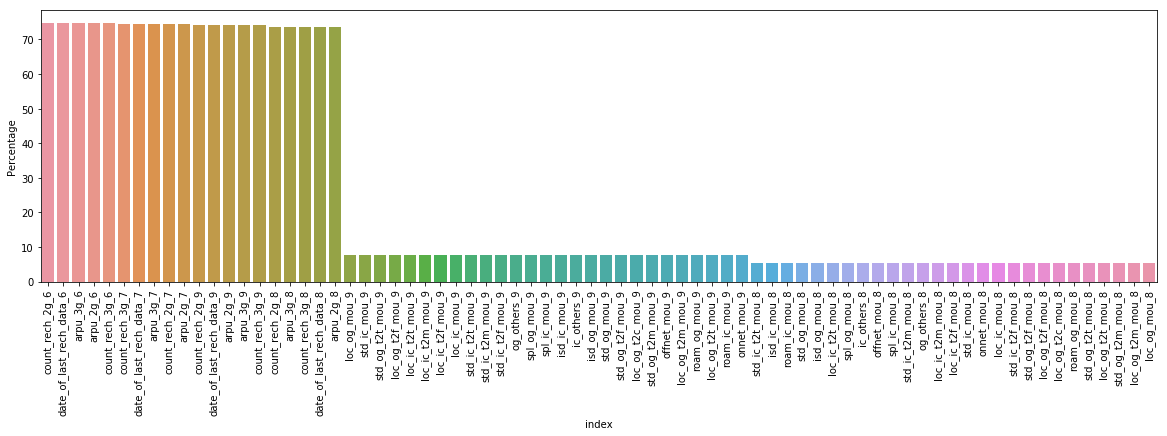

In [62]:
null_na_estimator_grph(telecom_df_base,5,graphical=True,size=(20,5))

#### Determining Churn for complete data-set

In [63]:
telecom_df_base['churn']=((telecom_df_base['total_ic_mou_9']+telecom_df_base['total_og_mou_9']>0) & (telecom_df_base['vol_2g_mb_9']+telecom_df_base['vol_3g_mb_9'])>0)
telecom_df_base.loc[:,'churn'].replace({True:1,False:0},inplace=True)

#### Feature Extraction : Date Columns

In [64]:
date_col=[x for x in telecom_df_base.columns if re.search('date',x)!=None]
null_date_col=null_na_estimator_grph(telecom_df_base[date_col],limit_val=0)
null_date_col

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_9    74.08
date_of_last_rech_data_8    73.66
date_of_last_rech_9          4.76
date_of_last_rech_8          3.62
date_of_last_rech_7          1.77
date_of_last_rech_6          1.61
dtype: float64

#### Now from above it looks like the date_of_last_rech_data_6/7/8/9 having 64 % of data as empty. Instead of impueting these variables at random the best opted way is to impute it wil date_of_last_rech which will result in duplication of the data, so we go ahead and drop these 4 cols and will focus on date_of_last_rech_6/7/8/9

In [65]:
print("We can validate that for the data where date_of_last_rech_6/7/8/9 is having null the respective data column is also null")
print(round(len(telecom_df_base[telecom_df_base['date_of_last_rech_6'].isnull() & telecom_df_base['date_of_last_rech_data_6'].isnull()])/len(telecom_df_base.index)*100,2))
print(round(len(telecom_df_base[telecom_df_base['date_of_last_rech_7'].isnull() & telecom_df_base['date_of_last_rech_data_7'].isnull()])/len(telecom_df_base.index)*100,2))
print(round(len(telecom_df_base[telecom_df_base['date_of_last_rech_8'].isnull() & telecom_df_base['date_of_last_rech_data_8'].isnull()])/len(telecom_df_base.index)*100,2))
print(round(len(telecom_df_base[telecom_df_base['date_of_last_rech_9'].isnull() & telecom_df_base['date_of_last_rech_data_9'].isnull()])/len(telecom_df_base.index)*100,2))

We can validate that for the data where date_of_last_rech_6/7/8/9 is having null the respective data column is also null
1.61
1.77
3.62
4.76


In [66]:
drop_col=['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']

In [67]:
date_df=telecom_df_base[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','churn']]
print(date_df.shape)

(99999, 5)


#### Dropping null rows where dates are not there

In [68]:
print(null_na_estimator_grph(date_df,limit_val=.2))
#date_df.dropna(subset=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9'],inplace=True)
print(date_df.shape)

date_of_last_rech_9    4.76
date_of_last_rech_8    3.62
date_of_last_rech_7    1.77
date_of_last_rech_6    1.61
dtype: float64
(99999, 5)


In [69]:
for col in date_df.columns.drop('churn'):
    date_df[col]=pd.to_datetime(date_df[col],format="%m/%d/%Y")
date_df['rech_day_6']=date_df['date_of_last_rech_6'].apply(lambda x: x.day)
date_df['rech_day_7']=date_df['date_of_last_rech_7'].apply(lambda x: x.day)
date_df['rech_day_8']=date_df['date_of_last_rech_8'].apply(lambda x: x.day)
date_df['rech_day_9']=date_df['date_of_last_rech_9'].apply(lambda x: x.day)

C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Text(0.5,1,'August churn rate')

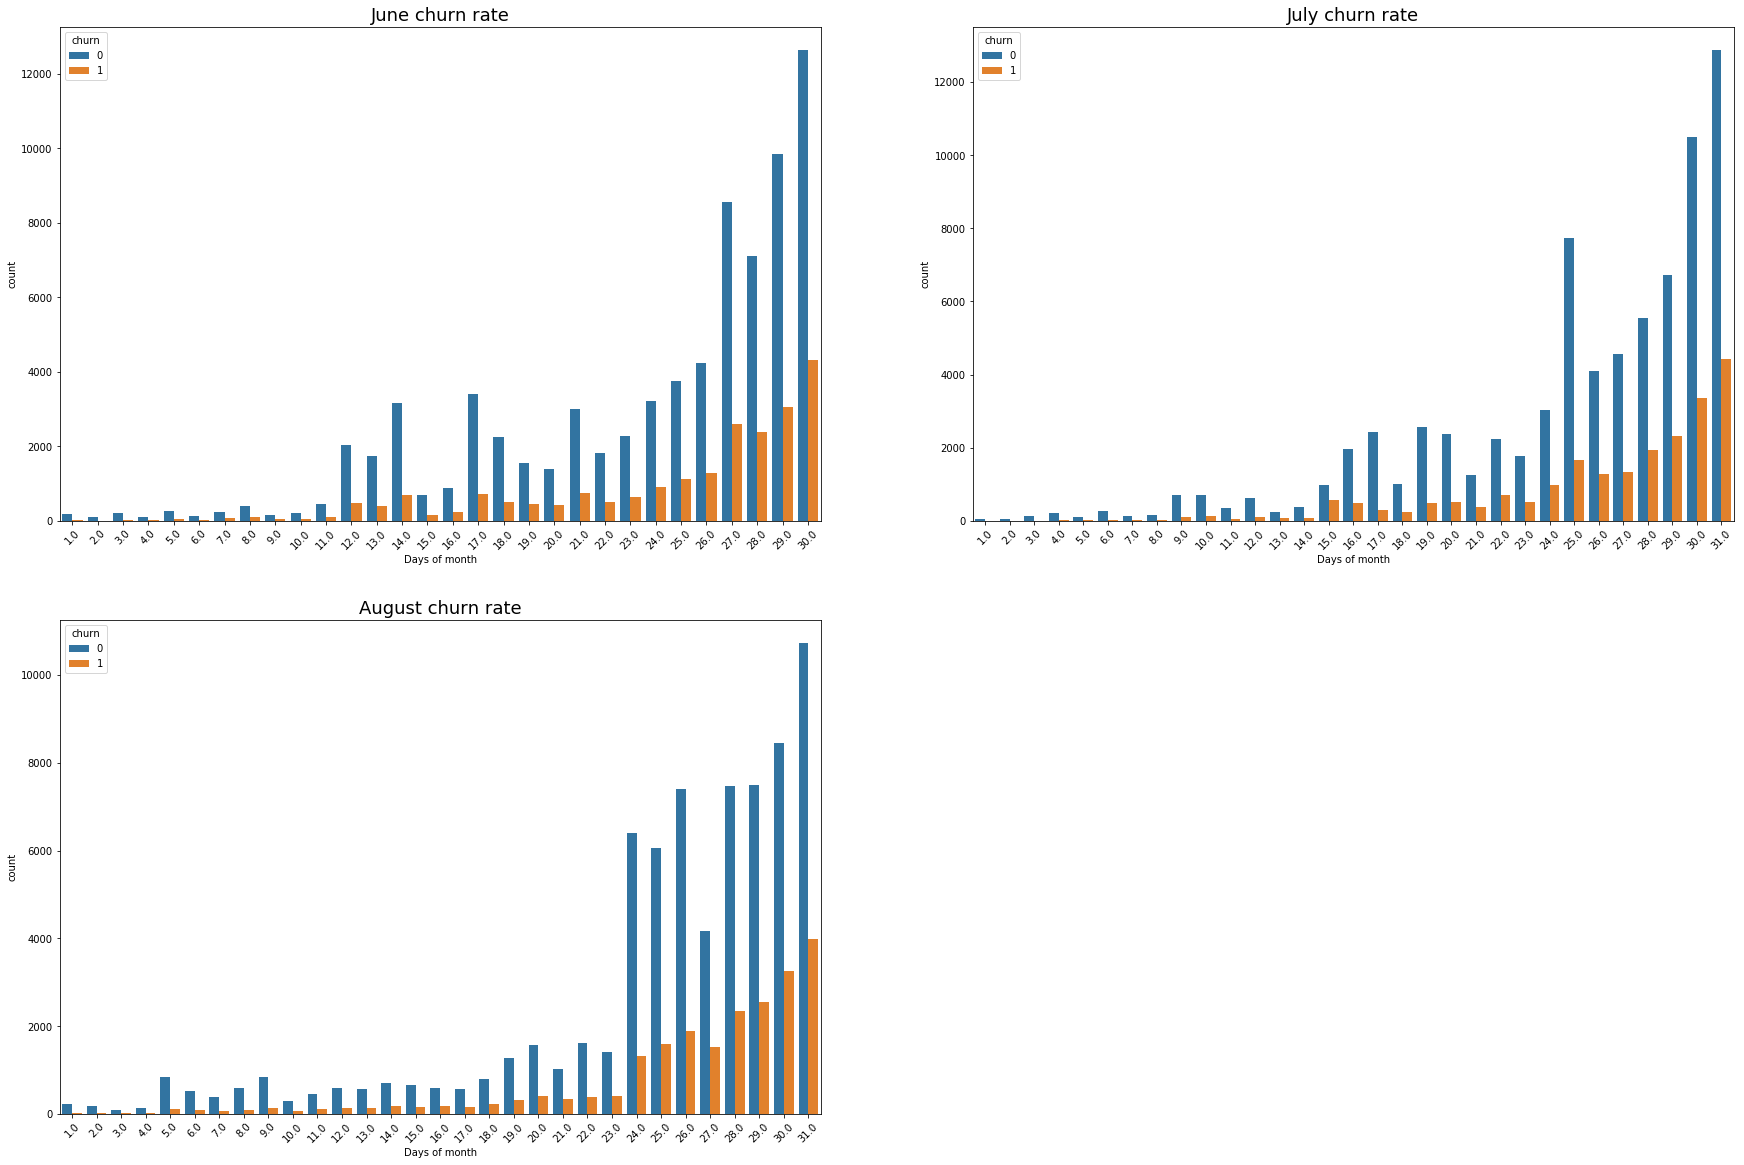

In [70]:
plt.figure(figsize=(30,20))
plt.subplot(221)
plt.xticks(rotation=45)
plt.title("June churn rate",fontsize=18)
sns.countplot(x='rech_day_6',hue='churn',data=date_df.sort_values(by='rech_day_6'))
plt.xlabel('Days of month')
#plt.figure(figsize=(10,5))
plt.subplot(222)
plt.xticks(rotation=45)
sns.countplot(x='rech_day_7',hue='churn',data=date_df.sort_values(by='rech_day_7'))
plt.xlabel('Days of month')
plt.title("July churn rate",fontsize=18)
plt.subplot(223)
#plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
sns.countplot(x='rech_day_8',hue='churn',data=date_df.sort_values(by='rech_day_8'))
plt.xlabel('Days of month')
plt.title("August churn rate",fontsize=18)

In [71]:
drop_col.extend(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9'])

In [72]:
drop_col
telecom_df_base=pd.concat([telecom_df_base,date_df[['rech_day_6','rech_day_7','rech_day_8','rech_day_9']]],axis=1)

### Capturing behavioral metrics - Data Users, Facebook Users, Call usage

#### Data Usage

In [73]:
data_cols=['sachet_2g_6','sachet_3g_6','monthly_3g_6','monthly_2g_6','sachet_2g_7','sachet_3g_7','monthly_3g_7','monthly_2g_7',
           'sachet_2g_8','sachet_3g_8','monthly_3g_8','monthly_2g_8','sachet_2g_9','sachet_3g_9','monthly_3g_9','monthly_2g_9']

In [74]:
null_na_estimator_grph(telecom_df_base[data_cols],limit_val=0)

monthly_2g_9    0.0
monthly_3g_9    0.0
sachet_3g_9     0.0
sachet_2g_9     0.0
monthly_2g_8    0.0
monthly_3g_8    0.0
sachet_3g_8     0.0
sachet_2g_8     0.0
monthly_2g_7    0.0
monthly_3g_7    0.0
sachet_3g_7     0.0
sachet_2g_7     0.0
monthly_2g_6    0.0
monthly_3g_6    0.0
sachet_3g_6     0.0
sachet_2g_6     0.0
dtype: float64

In [75]:
val_variance_estimator(telecom_df_base[data_cols])

,count,var
0,6,monthly_2g_7
1,27,sachet_3g_9
2,6,monthly_2g_8
3,32,sachet_2g_6
4,25,sachet_3g_6
5,35,sachet_2g_7
6,5,monthly_2g_6
7,27,sachet_3g_7
8,12,monthly_3g_8
9,29,sachet_3g_8


In [76]:
data_set_structure(telecom_df_base)

,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,2,2,2,2,0,8
Numeric,51,51,51,51,3,207


In [77]:
data_cols.append('churn')
data_usage=telecom_df_base[data_cols]
data_cols.remove('churn')

In [78]:
data_usage['Data_user_6']=(data_usage['monthly_3g_6']>0)|(data_usage['monthly_2g_6']>0)|(data_usage['sachet_3g_6']>0)|(data_usage['sachet_2g_6']>0)
data_usage['Data_user_7']=(data_usage['monthly_3g_7']>0)|(data_usage['monthly_2g_7']>0)|(data_usage['sachet_3g_7']>0)|(data_usage['sachet_2g_7']>0)
data_usage['Data_user_8']=(data_usage['monthly_3g_8']>0)|(data_usage['monthly_2g_8']>0)|(data_usage['sachet_3g_8']>0)|(data_usage['sachet_2g_8']>0)
data_usage['Data_user_9']=(data_usage['monthly_3g_9']>0)|(data_usage['monthly_2g_9']>0)|(data_usage['sachet_3g_9']>0)|(data_usage['sachet_2g_9']>0)

C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [79]:
data_usage.head()

,sachet_2g_6,sachet_3g_6,monthly_3g_6,monthly_2g_6,sachet_2g_7,sachet_3g_7,monthly_3g_7,monthly_2g_7,sachet_2g_8,sachet_3g_8,...,monthly_2g_8,sachet_2g_9,sachet_3g_9,monthly_3g_9,monthly_2g_9,churn,Data_user_6,Data_user_7,Data_user_8,Data_user_9
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,True,True,True,False
1,0,0,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,False,True,True,False
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,False,False,False,True
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,False,False,False,False
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,True,False,False,False


In [80]:
data_usage['Data_user_goodPhase']=(data_usage['Data_user_6'])|(data_usage['Data_user_7'])
data_usage['Data_user_complete']=(data_usage['Data_user_6'])|(data_usage['Data_user_7'])|(data_usage['Data_user_8'])

C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Churn -June + July + August')

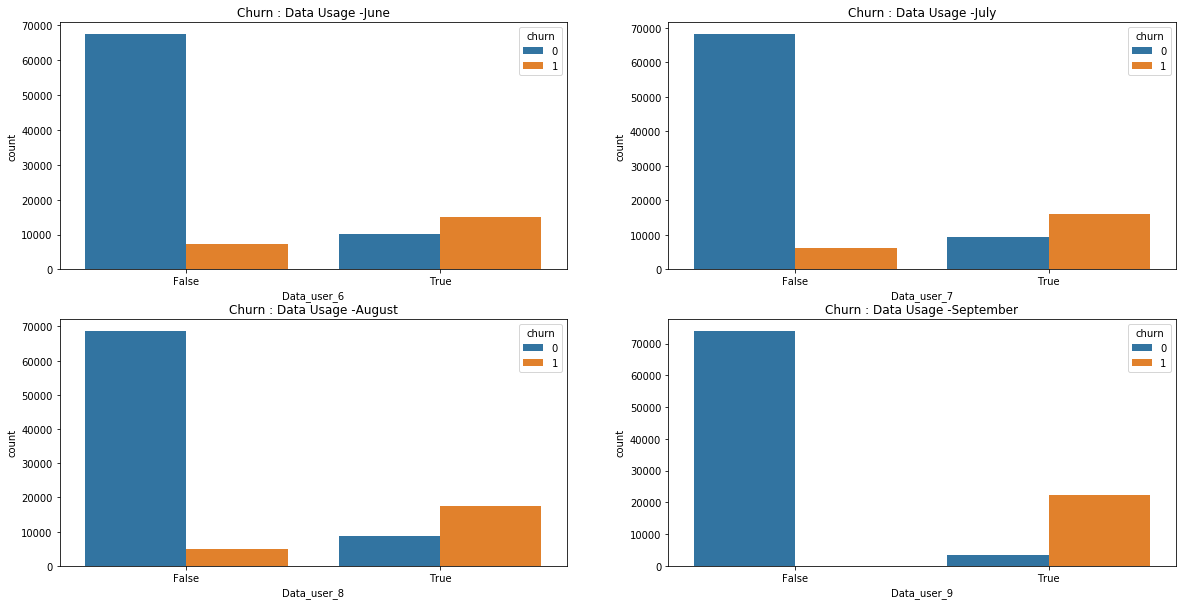

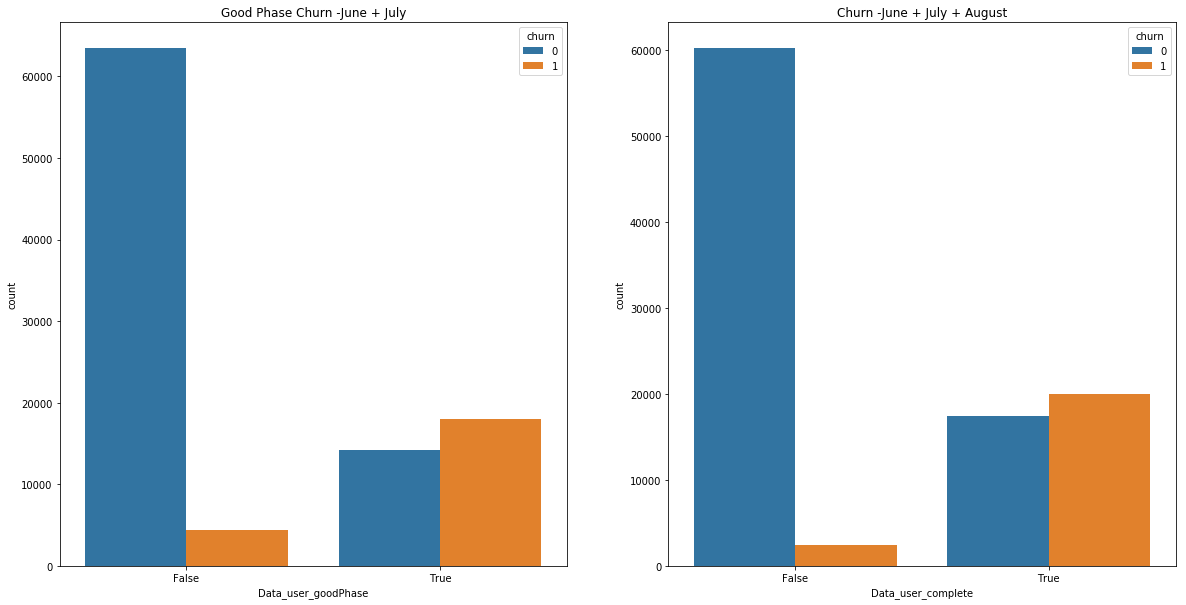

In [81]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.countplot(data=data_usage,x='Data_user_6',hue='churn')
plt.title('Churn : Data Usage -June')
plt.subplot(2,2,2)
sns.countplot(data=data_usage,x='Data_user_7',hue='churn')
plt.title('Churn : Data Usage -July')
plt.subplot(2,2,3)
sns.countplot(data=data_usage,x='Data_user_8',hue='churn')
plt.title('Churn : Data Usage -August')
plt.subplot(2,2,4)
sns.countplot(data=data_usage,x='Data_user_9',hue='churn')
plt.title('Churn : Data Usage -September')
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.countplot(data=data_usage,x='Data_user_goodPhase',hue='churn')
plt.title('Good Phase Churn -June + July')
plt.subplot(1,2,2)
sns.countplot(data=data_usage,x='Data_user_complete',hue='churn')
plt.title('Churn -June + July + August')

In [82]:
data_usage['Data_user_6']=data_usage['Data_user_6'].replace({True:1,False:0})
data_usage['Data_user_7']=data_usage['Data_user_7'].replace({True:1,False:0})
data_usage['Data_user_8']=data_usage['Data_user_8'].replace({True:1,False:0})
data_usage['Data_user_9']=data_usage['Data_user_9'].replace({True:1,False:0})
data_usage['Data_user_goodPhase']=data_usage['Data_user_goodPhase'].replace({True:1,False:0})
data_usage['Data_user_complete']=data_usage['Data_user_complete'].replace({True:1,False:0})

C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [83]:
drop_col.extend(data_cols)
drop_col

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'sachet_2g_6',
 'sachet_3g_6',
 'monthly_3g_6',
 'monthly_2g_6',
 'sachet_2g_7',
 'sachet_3g_7',
 'monthly_3g_7',
 'monthly_2g_7',
 'sachet_2g_8',
 'sachet_3g_8',
 'monthly_3g_8',
 'monthly_2g_8',
 'sachet_2g_9',
 'sachet_3g_9',
 'monthly_3g_9',
 'monthly_2g_9']

In [84]:
telecom_df_base=pd.concat([telecom_df_base,data_usage[['Data_user_6','Data_user_7','Data_user_8','Data_user_9','Data_user_goodPhase','Data_user_complete']]],axis=1)
data_set_structure(telecom_df_base)

,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,2,2,2,2,0,8
Numeric,52,52,52,52,5,213


In [85]:
print(telecom_df_base.shape)

(99999, 221)


##### Facebook Users

In [86]:
#telecom_df_base[['fb_user_6','fb_user_7','fb_user_8']]

In [87]:
null_na_estimator_grph(telecom_df_base[['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9','max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9']],limit_val=0)

count_rech_3g_6    74.85
count_rech_2g_6    74.85
count_rech_3g_7    74.43
count_rech_2g_7    74.43
count_rech_3g_9    74.08
count_rech_2g_9    74.08
count_rech_3g_8    73.66
count_rech_2g_8    73.66
max_rech_data_9     0.00
max_rech_data_8     0.00
max_rech_data_7     0.00
max_rech_data_6     0.00
dtype: float64

In [88]:
mrd_7=pd.DataFrame(telecom_df_base.groupby(['max_rech_data_7'])['churn'].count())
mrd_6=pd.DataFrame(telecom_df_base.groupby(['max_rech_data_6'])['churn'].count())
mrd_8=pd.DataFrame(telecom_df_base.groupby(['max_rech_data_8'])['churn'].count())

In [89]:
mrd_7.reset_index(inplace=True)
mrd_7.rename(columns={'max_rech_data_7':'Data_Plans','churn':'bought'},inplace=True)
mrd_8.reset_index(inplace=True)
mrd_8.rename(columns={'max_rech_data_8':'Data_Plans','churn':'bought'},inplace=True)
mrd_6.reset_index(inplace=True)
mrd_6.rename(columns={'max_rech_data_6':'Data_Plans','churn':'bought'},inplace=True)
merged_mrd=pd.concat([mrd_6,mrd_7,mrd_8],axis=0)
data_plan_popularity=pd.DataFrame(merged_mrd.groupby('Data_Plans')['bought'].sum())

In [90]:
data_plan_popularity.reset_index(inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text xticklabel objects>)

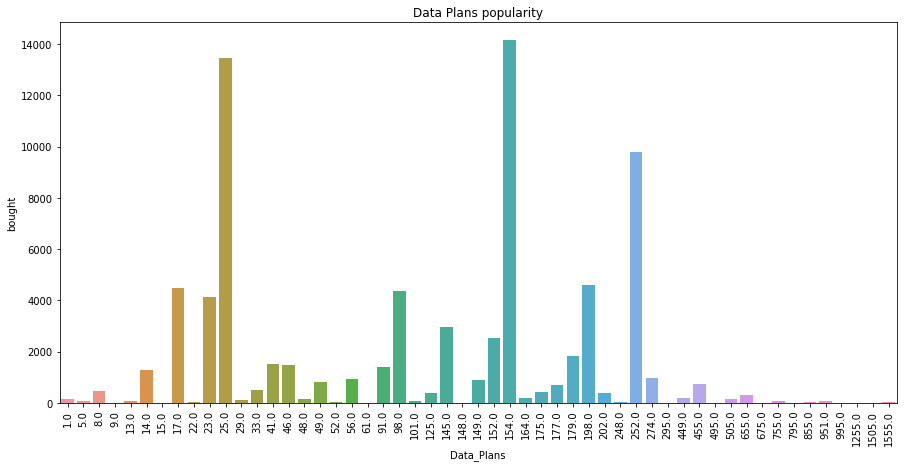

In [91]:
from sklearn.preprocessing import scale
#print(scale(data_plan_popularity['bought'],axis=0))
data_plan_popularity.sort_values(by='Data_Plans',inplace=True,ascending=True)
plt.figure(figsize=(15,7))
sns.barplot(data_plan_popularity['Data_Plans'][1:],data_plan_popularity['bought'][1:])
plt.title('Data Plans popularity')
plt.xticks(rotation=90)

In [92]:
data_plan_popularity[data_plan_popularity['Data_Plans']==0.0]

,Data_Plans,bought
0,0.0,222934


In [93]:
# We can see that many of the data is missing in the columns and for max_data_* columns 0 is having maximum value
# as we can't determine if this is as part of base plan data is given or not
# We should consider dropping variable 'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9'
# and leave columns 'max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9'
drop_col.extend(['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9'])

In [94]:
val_variance_estimator(telecom_df_base.drop(drop_col,axis=1))

,count,var
0,2451,std_og_t2f_mou_6
1,5845,isd_ic_mou_8
2,40074,total_og_mou_8
3,27698,loc_ic_mou_9
4,51,max_rech_data_8
5,20019,std_og_t2m_mou_7
6,27952,std_og_mou_7
7,8064,arpu_3g_9
8,3966,spl_og_mou_6
9,20545,loc_og_t2m_mou_8


In [95]:
num_col

['aon',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_2g_9',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_3g_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9',
 'circle_id',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'ic_others_9',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_ic_mou_9',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'isd_og_mou_9',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'last_day_rch_amt_9',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'loc_ic_mou_9',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_t2f_mou_9',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_i

#### Average Revenue

In [96]:
average_revenue_cols=['arpu_2g_6','arpu_3g_6','arpu_6',
                      'arpu_2g_7','arpu_3g_7','arpu_7',
                      'arpu_2g_8', 'arpu_3g_8','arpu_8',
                      'arpu_2g_9', 'arpu_3g_9','arpu_9']

In [97]:
print(telecom_df_base[average_revenue_cols].isnull().sum())
print(telecom_df_base[['arpu_2g_6','arpu_3g_6','arpu_6']].iloc[[0,4,19,30]])
## from below it is visible that average revenue column for each month doesn't adds up so we will impute the same.
## as total_arpu_6=arpu_2g_6 + arpu_3g_6 +  arpu_6
## for arpu_2g_6  arpu_3g_6   arpu_6 where NA we will impute it to 0 however imputing with median is also a feasible option

arpu_2g_6    74846
arpu_3g_6    74846
arpu_6           0
arpu_2g_7    74428
arpu_3g_7    74428
arpu_7           0
arpu_2g_8    73660
arpu_3g_8    73660
arpu_8           0
arpu_2g_9    74077
arpu_3g_9    74077
arpu_9           0
dtype: int64
    arpu_2g_6  arpu_3g_6   arpu_6
0      212.17     212.17  197.385
4        0.00       0.00  261.636
19       3.01       0.00  163.430
30        NaN        NaN    0.700


In [98]:
print(telecom_df_base[average_revenue_cols].median())
print(telecom_df_base[average_revenue_cols].describe())

arpu_2g_6     10.830
arpu_3g_6      0.480
arpu_6       197.704
arpu_2g_7      8.810
arpu_3g_7      0.420
arpu_7       191.640
arpu_2g_8      9.270
arpu_3g_8      0.880
arpu_8       192.080
arpu_2g_9     14.800
arpu_3g_9      2.605
arpu_9       176.849
dtype: float64
          arpu_2g_6     arpu_3g_6        arpu_6     arpu_2g_7     arpu_3g_7  \
count  25153.000000  25153.000000  99999.000000  25571.000000  25571.000000   
mean      86.398003     89.555057    282.987358     85.914450     89.384120   
std      172.767523    193.124653    328.439770    176.379871    195.893924   
min      -35.830000    -30.820000  -2258.709000    -15.480000    -26.040000   
25%        0.000000      0.000000     93.411500      0.000000      0.000000   
50%       10.830000      0.480000    197.704000      8.810000      0.420000   
75%      122.070000    122.070000    371.060000    122.070000    119.560000   
max     6433.760000   6362.280000  27731.088000   4809.360000   4980.900000   

             arpu_7  

In [99]:
average_revenue_cols.append('churn')
avg_call_df=telecom_df_base[average_revenue_cols]
print(avg_call_df.head())
average_revenue_cols.remove('churn')
#print(average_revenue_cols)

   arpu_2g_6  arpu_3g_6   arpu_6  arpu_2g_7  arpu_3g_7   arpu_7  arpu_2g_8  \
0     212.17     212.17  197.385     212.17     212.17  214.816     212.17   
1        NaN        NaN   34.047      28.61       0.00  355.074       7.60   
2        NaN        NaN  167.690        NaN        NaN  189.058        NaN   
3        NaN        NaN  221.338        NaN        NaN  251.102        NaN   
4       0.00       0.00  261.636        NaN        NaN  309.876        NaN   

   arpu_3g_8   arpu_8  arpu_2g_9  arpu_3g_9   arpu_9  churn  
0     212.17  213.803        NaN        NaN   21.100      0  
1       0.00  268.321        NaN        NaN   86.285      0  
2        NaN  210.226        0.0       2.84  290.714      1  
3        NaN  508.054        NaN        NaN  389.500      0  
4        NaN  238.174        NaN        NaN  163.426      0  


In [100]:
for i in np.array(average_revenue_cols).reshape(4,3):
    col_name=i[0].split('_')[-1]
    ## Filling value with median
    avg_call_df[i[0]].fillna(avg_call_df[i[0]].median(),inplace=True)
    avg_call_df[i[1]].fillna(avg_call_df[i[1]].median(),inplace=True)
    avg_call_df[i[2]].fillna(avg_call_df[i[2]].median(),inplace=True)
    avg_call_df['total_arpu_'+col_name]=avg_call_df[i[0]]+ avg_call_df[i[1]]+avg_call_df[i[2]]

C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [112]:
avg_call_df.groupby(['churn'])[['total_arpu_6','total_arpu_7','total_arpu_8','arpu_6','arpu_7','arpu_8']].count()

,total_arpu_6,total_arpu_7,total_arpu_8,arpu_6,arpu_7,arpu_8
churn,,,,,,
0,77614,77614,77614,77614,77614,77614
1,22385,22385,22385,22385,22385,22385


In [115]:
##The pattern remain same so we can consdier dropping all the columns combining them in total_arpu_6
#sns.countplot(data=avg_call_df,hue='churn',x='total_arpu_6')
#sns.lmplot(data=avg_call_df,x='Attack',y='total_arpu_6', hue='churn', fit_reg=False)
average_revenue_cols.append('churn')
print(telecom_df_base[average_revenue_cols].groupby('churn')[['arpu_6','arpu_7','arpu_8']].count())
average_revenue_cols.remove('churn')

       arpu_6  arpu_7  arpu_8
churn                        
0       77614   77614   77614
1       22385   22385   22385


In [118]:
drop_col.extend(average_revenue_cols)
telecom_df_base=pd.concat([telecom_df_base,avg_call_df[['total_arpu_6','total_arpu_7','total_arpu_8','total_arpu_9']]],axis=1)

In [126]:
drop_col.append('mobile_number')

In [139]:
#temp=telecom_df_base.drop(drop_col,axis=1)
#temp.to_csv('telecom_churn_features_truncated.csv')

In [140]:
data_set_structure(temp)

,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,0,0,0,0,0,0
Numeric,44,44,44,44,4,180


In [129]:
non_num_col,num_col,col_6,col_7,col_8,col_9=data_set_structure(temp,True)

#### EDA Finished

#### REmvoing all col with 9

In [189]:
#hv_filter_col=['total_rech_amt_6','av_rech_amt_data_6','total_rech_amt_7','av_rech_amt_data_7',
#'total_rech_amt_8','av_rech_amt_data_8','total_rech_amt_9','av_rech_amt_data_9']

hv_filter_col=['total_rech_amt_6','total_rech_data_6','total_rech_amt_7','total_rech_data_7',
'total_rech_amt_8','total_rech_data_8','total_rech_amt_9','total_rech_data_9']
#hv_filter_col=['total_rech_amt_6','total_rech_data_6','total_rech_num_6','total_rech_num_7','total_rech_amt_7','total_rech_data_7','total_rech_num_8','total_rech_amt_8','total_rech_data_8','total_rech_num_9','total_rech_amt_9','total_rech_data_9']
print("PRE-Computation: analysis for na/null\n",temp[hv_filter_col].isnull().sum())

PRE-Computation: analysis for na/null
 total_rech_amt_6     0
total_rech_data_6    0
total_rech_amt_7     0
total_rech_data_7    0
total_rech_amt_8     0
total_rech_data_8    0
total_rech_amt_9     0
total_rech_data_9    0
dtype: int64


In [190]:
telecom_df_base=temp.copy()

#### Hi Shashi, I have confirmed that you have to follow the same approach as mentioned in my previous mail.

To filter high-value customers, you need to consider the total recharge amount and to calculate the total recharge amount, you need to calculate the sum of total call recharge amount and total data recharge amount. In other words, total recharge amount = call recharge amount + data recharge amount.

In [196]:
print("Filtering high value customers")
telecom_df_base['total_month_rech_6']=telecom_df_base.loc[:,hv_filter_col[0]]+telecom_df_base.loc[:,hv_filter_col[1]]
telecom_df_base['total_month_rech_7']=telecom_df_base.loc[:,hv_filter_col[2]]+telecom_df_base.loc[:,hv_filter_col[3]]
telecom_df_base['total_month_rech_8']=telecom_df_base.loc[:,hv_filter_col[4]]+telecom_df_base.loc[:,hv_filter_col[5]]
telecom_df_base['total_month_rech_9']=telecom_df_base.loc[:,hv_filter_col[6]]+telecom_df_base.loc[:,hv_filter_col[7]]

hv_percentile=(telecom_df_base['total_month_rech_6']+telecom_df_base['total_month_rech_7']).quantile(.7)
print("high value customer cut-off: ",hv_percentile)
telecom_data_analysis=telecom_df_base[telecom_df_base.loc[:,'total_month_rech_6']+telecom_df_base.loc[:,'total_month_rech_7']>hv_percentile]

print("Dimension of High value customer dataset: ",telecom_data_analysis.shape)

Filtering high value customers
high value customer cut-off:  739.0
Dimension of High value customer dataset:  (29991, 184)


In [197]:
data_set_structure(telecom_data_analysis)

,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,0,0,0,0,0,0
Numeric,45,45,45,45,4,184


In [198]:
telecom_data_analysis[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].isnull().sum()

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [199]:
telecom_data_analysis['churn']=((telecom_data_analysis['total_ic_mou_9']+telecom_data_analysis['total_og_mou_9']>0) & (telecom_data_analysis['vol_2g_mb_9']+telecom_data_analysis['vol_3g_mb_9'])>0)
telecom_data_analysis.loc[:,'churn'].replace({True:1,False:0},inplace=True)

C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Text(0.5,1,'Telcom Churn Rate')

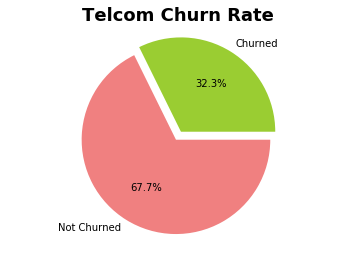

In [200]:
plt.pie(x=[len(telecom_data_analysis[telecom_data_analysis['churn']==1]),len(telecom_data_analysis[telecom_data_analysis['churn']==0])],labels=['Churned','Not Churned'],autopct='%1.1f%%',colors=['yellowgreen', 'lightcoral'],explode=(.1,0))
plt.axis('equal')
plt.title('Telcom Churn Rate',fontsize=18,fontweight='bold')

In [201]:
non_num_col,num_col,col_6,col_7,col_8,col_9=data_set_structure(telecom_data_analysis,True)

In [203]:
telecom_data_analysis.drop(col_9,inplace=True,axis=1)

C:\ProgramData\Anaconda2\envs\DS_3_6\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [204]:
data_set_structure(telecom_data_analysis)

,Month 6,Month 7,Month 8,Month 9,Common,Total
Non-Numeric,0,0,0,0,0,0
Numeric,45,45,45,0,4,139


In [206]:
null_col=null_na_estimator_grph(telecom_data_analysis,limit_val=0.5)

In [219]:
telecom_data_analysis=telecom_data_analysis.fillna(0,axis=0)

#### Model Building

In [220]:

X_reg = telecom_data_analysis.drop('churn',axis=1)
y_reg = telecom_data_analysis.loc[:,'churn']

In [224]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg,y_reg,train_size=0.7,test_size=0.3,random_state=100)

In [225]:
pca = PCA(n_components=20)
scaler = StandardScaler()

X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

In [226]:
x_pca = pca.fit_transform(X_train_reg)
lr = LogisticRegression()
lr.fit(x_pca,y_train_reg)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [227]:
x_test_pca = pca.transform(X_test_reg)
y_pred = lr.predict(x_test_pca)

In [228]:
metrics.confusion_matrix(y_test_reg,y_pred)

array([[5544,  572],
       [ 744, 2138]], dtype=int64)

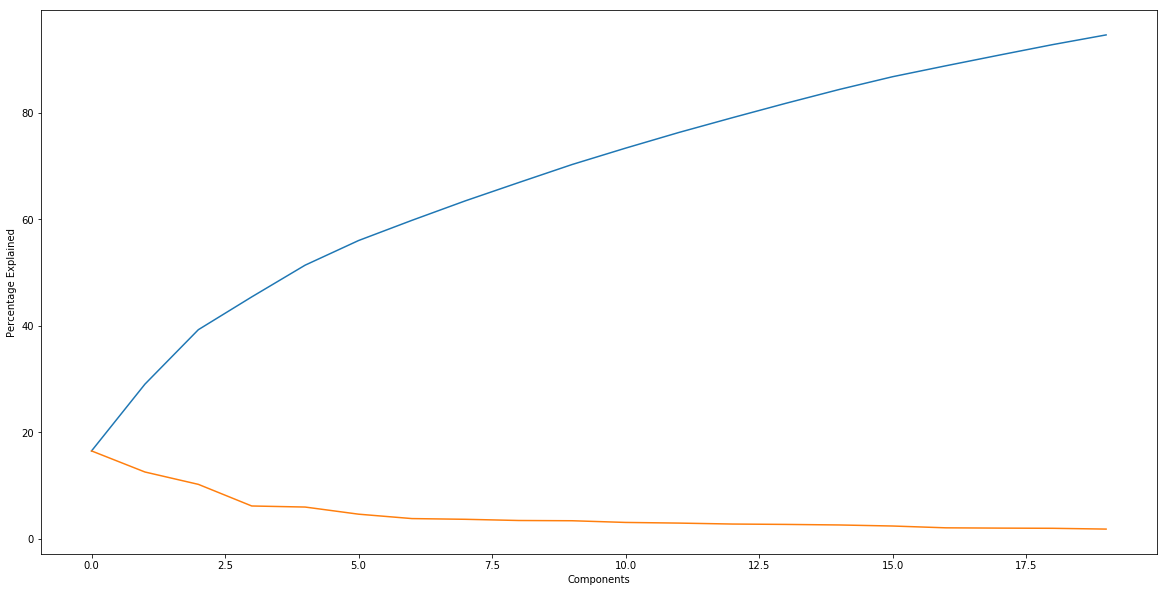

In [229]:
plt.figure(figsize=(20,10))
plt.xlabel('Components')
plt.ylabel('Percentage Explained')
plt.plot(np.cumsum(pca.explained_variance_))
plt.plot(pca.explained_variance_)
plt.show()

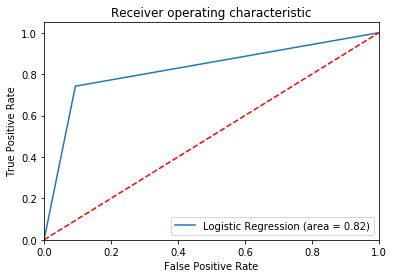

In [230]:
# ROC curve - Logistics
logit_roc_auc = metrics.roc_auc_score(y_test_reg, y_pred)
#fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test_reg, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [231]:
logRegression = LogisticRegression()
rfe = RFE(logRegression,20)
rfe.fit(X_train_reg,y_train_reg)

KeyboardInterrupt: 

In [ ]:
print(rfe.ranking_)
print(rfe.estimator_)
print(rfe.n_features_)
print(rfe.support_)

In [ ]:
telecom_data_analysis_rfe = X_reg.loc[:,rfe.support_]

In [ ]:
telecom_data_analysis_rfe.columns